In [1]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 618, done.
remote: Total 618 (delta 0), reused 0 (delta 0), pack-reused 618 (from 1)
Receiving objects: 100% (618/618), 47.42 MiB | 39.80 MiB/s, done.
Resolving deltas: 100% (338/338), done.


In [2]:
%cd Pytorch-UNet

/content/Pytorch-UNet


In [28]:
from unet import UNet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=8, n_classes=1, bilinear=True)
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#import zipfile
#import os

#zip_path = '/content/drive/MyDrive/Brick_Data_Train_subset.zip'  # replace with your actual path
#extract_to = '/content/drive/MyDrive/Brick_Data_Train_subset'  # or wherever you want

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

In [30]:
import tifffile
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
from os import listdir
from os.path import splitext, isfile, join
import logging
from PIL import Image
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
import torch
import torch.nn.functional as F # Import F for padding

def load_image(filename):
    # This function is not needed for .tif files as tifffile.imread handles loading
    pass

def unique_mask_values(idx, mask_dir, mask_suffix):
    mask_file = list(mask_dir.glob(idx + mask_suffix + '.*'))
    if not mask_file:
        raise FileNotFoundError(f"Mask file not found for ID: {idx}")
    mask_file = mask_file[0]
    mask = tifffile.imread(str(mask_file)).astype(np.uint8)
    if mask.ndim == 3:
        mask = mask[:, :, 0] # Take the first channel if it's an RGB mask
    return np.unique(mask)


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, mask_dir: str, scale: float = 1.0, mask_suffix: str = '', pad_to_multiple: int = 32):
        self.images_dir = Path(images_dir)
        self.mask_dir = Path(mask_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.pad_to_multiple = pad_to_multiple # Added padding attribute

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if isfile(join(images_dir, file)) and not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')

        logging.info(f'Creating dataset with {len(self.ids)} examples')
        logging.info('Scanning mask files to determine unique values')
        # Use a smaller pool size or adjust based on your system resources if needed
        with Pool(processes=4) as p:
             unique = list(tqdm(
                 p.imap(partial(unique_mask_values, mask_dir=self.mask_dir, mask_suffix=self.mask_suffix), self.ids),
                 total=len(self.ids)
             ))


        self.mask_values = list(sorted(np.unique(np.concatenate(unique)).tolist()))
        logging.info(f'Unique mask values: {self.mask_values}')


    def __getitem__(self, idx):
        name = self.ids[idx]
        img_file = list(self.images_dir.glob(name + '.*'))
        mask_file = list(self.mask_dir.glob(name + self.mask_suffix + '.*'))

        if not img_file:
             raise FileNotFoundError(f"Image file not found for ID: {name}")
        if not mask_file:
             raise FileNotFoundError(f"Mask file not found for ID: {name}")

        img = tifffile.imread(str(img_file[0])).astype(np.float32)  # [H, W, C]
        img = np.nan_to_num(img, nan=0.0)

        mask = tifffile.imread(str(mask_file[0])).astype(np.uint8)

        # Handle potential scaling (optional, based on original BasicDataset)
        # if self.scale != 1.0:
        #     img = self.scale_image(img, self.scale)
        #     mask = self.scale_image(mask, self.scale)

        if img.ndim == 3:
            img = img.transpose(2, 0, 1)  # to [C, H, W]
        elif img.ndim == 2: # Handle grayscale images by adding a channel dimension
             img = np.expand_dims(img, axis=0)

        if mask.ndim == 3:
            mask = mask[:, :, 0]  # in case of RGB mask

        # Convert mask to binary (0 and 1)
        # Assuming all non-zero values represent the foreground
        mask = (mask > 0).astype(np.uint8)

        # Convert to tensors before padding
        img_tensor = torch.from_numpy(img)
        mask_tensor = torch.from_numpy(mask).long()

        # Pad images and masks to be divisible by pad_to_multiple
        _, h, w = img_tensor.shape
        pad_h = (self.pad_to_multiple - (h % self.pad_to_multiple)) % self.pad_to_multiple
        pad_w = (self.pad_to_multiple - (w % self.pad_to_multiple)) % self.pad_to_multiple

        # Pad image tensor (C, H, W)
        img_tensor = F.pad(img_tensor, (0, pad_w, 0, pad_h))

        # Pad mask tensor (H, W) - need to add channel dimension for F.pad
        mask_tensor = mask_tensor.unsqueeze(0) # Add channel dimension
        mask_tensor = F.pad(mask_tensor, (0, pad_w, 0, pad_h))
        mask_tensor = mask_tensor.squeeze(0) # Remove channel dimension

        return {
            'image': img_tensor,
            'mask': mask_tensor
        }

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        # This method is from the original BasicDataset but is not directly used
        # with tifffile. It's kept here for reference or if needed for other image types
        pass

    @staticmethod
    def scale_image(img, scale):
        # Placeholder for image scaling if needed
        # You would need to implement image resizing here (e.g., using OpenCV or PIL)
        return img

In [8]:
!pip install importlib

  Preparing metadata (setup.py) ... done
  Created wheel for importlib: filename=importlib-1.0.4-py3-none-any.whl size=5850 sha256=507919e0b73878abc4ab55ba5a04e4c24fc639b592c864d72b334d01a9d974ee
  Stored in directory: /root/.cache/pip/wheels/03/4a/6e/7c4a313549653a504574fa29f907139c752051ef05210df605
Successfully built importlib


In [31]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

from utils.dice_score import multiclass_dice_coeff, dice_coeff


@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.long)

            # predict the mask
            mask_pred = net(image)

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = F.sigmoid(mask_pred) # Apply sigmoid here
                mask_pred = (mask_pred > 0.5).float()
                # Squeeze the predicted mask to remove the channel dimension
                mask_pred = mask_pred.squeeze(1)
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

In [ ]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from unet import UNet
from utils.dice_score import dice_loss

dir_checkpoint = Path('./checkpoints/')

import importlib
import utils.dice_score
importlib.reload(utils.dice_score)
from utils.dice_score import dice_loss


def train_model(
        model,
        device,
        epochs: int = 100,
        batch_size: int = 16,
        learning_rate: float = 1e-4,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 1,
        amp: bool = True,
        weight_decay: float = 1e-5,
        momentum: float = 0.9,
        gradient_clipping: float = 1.0,
):
    dataset = BasicDataset('/content/drive/MyDrive/Brick_Data_Train_subset/Brick_Data_Train/Image', '/content/drive/MyDrive/Brick_Data_Train_subset/Brick_Data_Train/Mask')

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    print(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for binary segmentation
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                print({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            if not value.requires_grad:
                                continue  # skip frozen layers
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        print('Validation Dice score: {}'.format(val_score))
                        try:
                            print({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks')
    parser.add_argument('--epochs', '-e', metavar='E', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', metavar='B', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', metavar='LR', type=float, default=1e-5,
                        help='Learning rate', dest='lr')
    parser.add_argument('--load', '-f', type=str, default=False, help='Load model from a .pth file')
    parser.add_argument('--scale', '-s', type=float, default=0.5, help='Downscaling factor of the images')
    parser.add_argument('--validation', '-v', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')
    parser.add_argument('--amp', action='store_true', default=False, help='Use mixed precision')
    parser.add_argument('--bilinear', action='store_true', default=False, help='Use bilinear upsampling')
    parser.add_argument('--classes', '-c', type=int, default=2, help='Number of classes')

    return parser.parse_args()


train_model(model=model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

 29%|██▊       | 287/999 [00:09<00:17, 41.50it/s]

In [33]:
dataset = BasicDataset('/content/drive/MyDrive/Brick_Data_Train_subset/Brick_Data_Train/Image', '/content/drive/MyDrive/Brick_Data_Train_subset/Brick_Data_Train/Mask')

100%|██████████| 999/999 [00:21<00:00, 47.46it/s]


In [34]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Find an image with a positive mask
positive_sample_idx = -1
for i in range(len(dataset)):
    sample = dataset[i]
    if torch.sum(sample['mask']) > 0:  # Check if the mask has any positive pixels
        positive_sample_idx = i
        break

Original image shape: torch.Size([8, 256, 256])
Mask shape: torch.Size([256, 256])


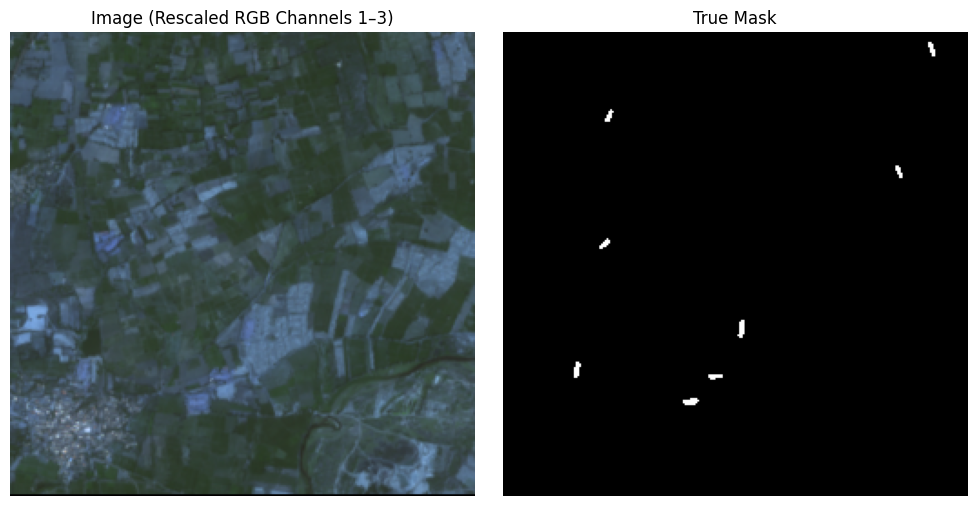

Raw prediction stats:
min: 0.1907675564289093 max: 0.40086498856544495 mean: 0.22467806935310364


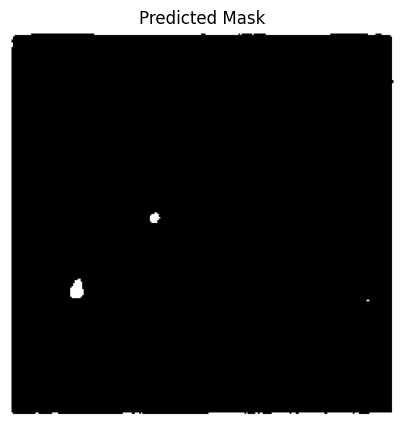

In [44]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

if positive_sample_idx != -1:
    # Load the sample
    sample_to_visualize = dataset[positive_sample_idx]
    image_to_visualize = sample_to_visualize['image']  # [C, H, W]
    true_mask_to_visualize = sample_to_visualize['mask']  # [H, W]

    print("Original image shape:", image_to_visualize.shape)
    print("Mask shape:", true_mask_to_visualize.shape)

    # ---- RGB Display Prep (Channels 1–3) ----
    rgb_img = image_to_visualize[:3, :, :].permute(1, 2, 0).cpu().numpy()  # [H, W, 3]

    # Rescale values to [0, 1] for visualization only
    rgb_min = rgb_img.min()
    rgb_max = rgb_img.max()
    if rgb_max > rgb_min:
        rgb_img_disp = (rgb_img - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb_img_disp = rgb_img  # Fallback: flat image

    # Convert mask for plotting
    mask_np = true_mask_to_visualize.cpu().numpy()

    # ---- Visualization ----
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(rgb_img_disp)
    axes[0].set_title('Image (Rescaled RGB Channels 1–3)')
    axes[0].axis('off')

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('True Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # Model inference
    model.eval()
    with torch.no_grad():
        image_input = image_to_visualize.unsqueeze(0).to(
            device=device,
            dtype=torch.float32,
            memory_format=torch.channels_last
        )  # [1, C, H, W]

        predicted_mask_logits = model(image_input)

        # Convert logits to binary prediction
        predicted_mask = F.sigmoid(predicted_mask_logits).squeeze(0).squeeze(0)  # [H, W]
        print("Raw prediction stats:")
        print("min:", predicted_mask.min().item(), "max:", predicted_mask.max().item(), "mean:", predicted_mask.mean().item())


        predicted_mask = (predicted_mask > 0.25).float()

    # Display predicted mask
    plt.figure(figsize=(5, 5))
    plt.imshow(predicted_mask.cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()
else:
    print("No images with positive masks found in the dataset.")


In [27]:
img = tifffile.imread("/content/drive/MyDrive/Brick_Data_Train_subset/Brick_Data_Train/Image/Image7839.tif")
print("dtype:", img.dtype)
print("min:", img.min(), "max:", img.max())

dtype: float32
min: -0.66779655 max: 0.8431752
